In [30]:
import os
import gc
import glob
from joblib import Parallel, delayed, dump, load
import pandas as pd
from pandas.core.common import flatten
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.cluster import KMeans
import scipy as sc
from sklearn.model_selection import KFold, GroupKFold
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")
pd.set_option("max_columns", 300)

# Parameters

In [33]:
CONFIG = {
    "root_dir": "../../input/optiver-realized-volatility-prediction/",
    "ckpt_dir": "../../ckpts",
    "kfold_seed": 42,
    "n_splits": 5,
    "n_clusters": 7,
}

PARAMS = {
        "objective": "rmse",
        "boosting_type": "gbdt",
        "max_depth": -1,
        "max_bin":100,
        "min_data_in_leaf":500,
        "learning_rate": 0.05,
        "subsample": 0.72,
        "subsample_freq": 4,
        "feature_fraction": 0.5,
        "lambda_l1": 0.5,
        "lambda_l2": 1.0,
        "categorical_column":[0],
        "seed":2021,
        "feature_fraction_seed": 2021,
        "bagging_seed": 2021,
        "drop_seed": 2021,
        "data_random_seed": 2021,
        "n_jobs":-1,
        "verbose": -1
}   

# Read train test

In [3]:
def read_train_test():
    
    train = pd.read_csv("../../input/optiver-realized-volatility-prediction/train.csv")
    test = pd.read_csv("../../input/optiver-realized-volatility-prediction/test.csv")
    
    # Create a key to merge with book and trade data
    train["row_id"] = train["stock_id"].astype(str) + "-" + train["time_id"].astype(str)
    test["row_id"] = test["stock_id"].astype(str) + "-" + test["time_id"].astype(str)
    
    print("Our training set has {} rows".format(train.shape[0]))
    
    return train, test

# Define basic metric function

In [4]:
def activity_counts(df):
    activity_counts_ = df.groupby(["time_id"])["seconds_in_bucket"].agg("count").reset_index()
    activity_counts_ = activity_counts_.rename(columns={"seconds_in_bucket": "activity_counts"})
    return activity_counts_


def calc_wap(df, pos=1):
    wap = (df["bid_price{}".format(pos)] * df["ask_size{}".format(pos)] + df["ask_price{}".format(pos)] * df[
        "bid_size{}".format(pos)]) / (df["bid_size{}".format(pos)] + df["ask_size{}".format(pos)])
    return wap


def calc_wap2(df, pos=1):
    wap = (df["bid_price{}".format(pos)] * df["bid_size{}".format(pos)] + df["ask_price{}".format(pos)] * df[
        "ask_size{}".format(pos)]) / (df["bid_size{}".format(pos)] + df["ask_size{}".format(pos)])
    return wap


def wp(df):
    wp_ = (df["bid_price1"] * df["bid_size1"] + df["ask_price1"] * df["ask_size1"] + df["bid_price2"] * df[
        "bid_size2"] + df["ask_price2"] * df["ask_size2"]) / (
                  df["bid_size1"] + df["ask_size1"] + df["bid_size2"] + df["ask_size2"])
    return wp_


def maximum_drawdown(series, window=600):
    # window for 10 minutes, use min_periods=1 if you want to allow the expanding window
    roll_max = series.rolling(window, min_periods=1).max()
    second_drawdown = series / roll_max - 1.0
    max_drawdown = second_drawdown.rolling(window, min_periods=1).min()

    return max_drawdown


def log_return(series):
    return np.log(series).diff().fillna(0)


def rolling_log_return(series, rolling=60):
    return np.log(series.rolling(rolling)).diff().fillna(0)


def realized_volatility(series):
    return np.sqrt(np.sum(series ** 2))


def diff(series):
    return series.diff().fillna(0)


def time_diff(series):
    return series.diff().fillna(series)


def order_flow_imbalance(df, pos=1):
    df["bid_price{}_diff".format(pos)] = df.groupby(["time_id"])["bid_price{}".format(pos)].apply(diff)
    df["bid_size{}_diff".format(pos)] = df.groupby(["time_id"])["bid_price{}".format(pos)].apply(diff)
    df["bid_order_flow{}".format(pos)] = df["bid_size{}".format(pos)].copy(deep=True)
    df["bid_order_flow{}".format(pos)].loc[df["bid_price{}_diff".format(pos)] < 0] *= -1
    df["bid_order_flow{}".format(pos)].loc[df["bid_price{}_diff".format(pos)] == 0] = \
        df["bid_size{}_diff".format(pos)].loc[df["bid_price{}_diff".format(pos)] == 0]

    df["ask_price{}_diff".format(pos)] = df.groupby(["time_id"])["ask_price{}".format(pos)].apply(diff)
    df["ask_size{}_diff".format(pos)] = df.groupby(["time_id"])["ask_price{}".format(pos)].apply(diff)
    df["ask_order_flow{}".format(pos)] = df["ask_size{}".format(pos)].copy(deep=True)
    df["ask_order_flow{}".format(pos)].loc[df["ask_price{}_diff".format(pos)] < 0] *= -1
    df["ask_order_flow{}".format(pos)].loc[df["ask_price{}_diff".format(pos)] == 0] = \
        df["ask_size{}_diff".format(pos)].loc[df["ask_price{}_diff".format(pos)] == 0]

    order_flow_imbalance_ = df["bid_order_flow{}".format(pos)] - df["ask_order_flow{}".format(pos)]

    df.drop(["bid_price{}_diff".format(pos), "bid_size{}_diff".format(pos), "bid_order_flow{}".format(pos),
             "ask_price{}_diff".format(pos), "ask_size{}_diff".format(pos), "ask_order_flow{}".format(pos)], axis=1,
            inplace=True)

    return order_flow_imbalance_ + 1e-8


def order_book_slope(df):

    df["mid_point"] = (df["bid_price1"] + df["ask_price1"]) / 2
    best_mid_point_ = df.groupby(["time_id"])["mid_point"].agg("max").reset_index()
    best_mid_point_ = best_mid_point_.rename(columns={"mid_point": "best_mid_point"})
    df = df.merge(best_mid_point_, how="left", on="time_id")

    best_mid_point = df["best_mid_point"].copy()
    df.drop(["mid_point", "best_mid_point"], axis=1, inplace=True)

    def ratio(series):
        ratio_ = series / series.shift()
        return ratio_

    bid_price1_ratio = df.groupby(["time_id"])["bid_price1"].apply(ratio)
    bid_price1_mid_point_ratio = df["bid_price1"] / best_mid_point
    bid_price1_ratio = abs(bid_price1_ratio.fillna(bid_price1_mid_point_ratio) - 1)

    bid_size1_ratio = df.groupby(["time_id"])["bid_size1"].apply(ratio) - 1
    bid_size1_ratio = bid_size1_ratio.fillna(df["bid_size1"])
    df["DE"] = (bid_size1_ratio / bid_price1_ratio).replace([np.inf, -np.inf], np.nan).fillna(0)

    ask_price1_ratio = df.groupby(["time_id"])["ask_price1"].apply(ratio)
    ask_price1_mid_point_ratio = df["ask_price1"] / best_mid_point
    ask_price1_ratio = abs(ask_price1_ratio.fillna(ask_price1_mid_point_ratio) - 1)

    ask_size1_ratio = df.groupby(["time_id"])["ask_size1"].apply(ratio) - 1
    ask_size1_ratio = ask_size1_ratio.fillna(df["ask_size1"])
    df["SE"] = (ask_size1_ratio / ask_price1_ratio).replace([np.inf, -np.inf], np.nan).fillna(0)

    df["order_book_slope"] = (df["DE"] + df["SE"]) / 2
    order_book_slope_ = df.groupby(["time_id"])["order_book_slope"].agg("mean").reset_index()
    df.drop(["order_book_slope", "DE", "SE"], axis=1, inplace=True)

    return order_book_slope_


def ldispersion(df):
    LDispersion = 1 / 2 * (
            df["bid_size1"] / (df["bid_size1"] + df["bid_size2"]) * abs(df["bid_price1"] - df["bid_price2"]) + df[
        "ask_size1"] / (df["ask_size1"] + df["ask_size2"]) * abs(df["ask_price1"] - df["ask_price2"]))
    return LDispersion


def depth_imbalance(df, pos=1):
    depth_imbalance_ = (df["bid_size{}".format(pos)] - df["ask_size{}".format(pos)]) / (
            df["bid_size{}".format(pos)] + df["ask_size{}".format(pos)])

    return depth_imbalance_


def height_imbalance(df, pos=1):
    height_imbalance_ = (df["bid_price{}".format(pos)] - df["ask_price{}".format(pos)]) / (
            df["bid_price{}".format(pos)] + df["ask_price{}".format(pos)])

    return height_imbalance_


def pressure_imbalance(df):
    mid_price = (df["bid_price1"] + df["ask_price1"]) / 2

    weight_buy = mid_price / (mid_price - df["bid_price1"]) + mid_price / (mid_price - df["bid_price2"])
    pressure_buy = df["bid_size1"] * (mid_price / (mid_price - df["bid_price1"])) / weight_buy + df["bid_size2"] * (
            mid_price / (mid_price - df["bid_price2"])) / weight_buy

    weight_sell = mid_price / (df["ask_price1"] - mid_price) + mid_price / (df["ask_price2"] - mid_price)
    pressure_sell = df["ask_size1"] * (mid_price / (df["ask_price1"] - mid_price)) / weight_sell + df["ask_size2"] * (
            mid_price / (df["ask_price2"] - mid_price)) / weight_sell

    pressure_imbalance_ = np.log(pressure_buy) - np.log(pressure_sell)

    return pressure_imbalance_


def relative_spread(df, pos=1):
    relative_spread_ = 2 * (df["ask_price{}".format(pos)] - df["bid_price{}".format(pos)]) / (
            df["ask_price{}".format(pos)] + df["bid_price{}".format(pos)])

    return relative_spread_


def count_unique(series):
    return len(np.unique(series))

In [5]:
# df = pd.read_parquet("../../input/optiver-realized-volatility-prediction/book_train.parquet/stock_id=0")
# df["order_flow_imbalance1"] = order_flow_imbalance(df, 1)
# df["order_flow_imbalance2"] = order_flow_imbalance(df, 2)

# Processor

In [6]:
# Function to fill missing seconds (for each stock id)
def fill_missing_seconds(df):
    
    time_ids = list(OrderedDict.fromkeys(df["time_id"]))
    
    filled_df = pd.DataFrame(index=range(len(time_ids) * 600), columns=df.columns)
    
    all_seconds_in_bucket = list(flatten([range(600) for i in range(len(time_ids))]))
    filled_df["seconds_in_bucket"] = all_seconds_in_bucket
    
    all_time_ids = list(flatten([[time_ids[i]] * 600 for i in range(len(time_ids))]))
    filled_df["time_id"] = all_time_ids
    
    filled_df = pd.merge(filled_df, df, on=["time_id", "seconds_in_bucket"], how="left", suffixes=("_to_move", ""))
    
    to_remove_columns = [column for column in filled_df.columns if "to_move" in column]
    filled_df = filled_df.drop(to_remove_columns, axis=1)
    
    filled_df = filled_df.fillna(method="ffill")
    
    return filled_df

In [7]:
# Function to preprocess book data (for each stock id)
def book_preprocessor(file_path):
    df = pd.read_parquet(file_path)

    # float 64 to float 32
    float_cols = df.select_dtypes(include=[np.float64]).columns
    df[float_cols] = df[float_cols].astype(np.float32)

    # int 64 to int 32
    int_cols = df.select_dtypes(include=[np.int64]).columns
    df[int_cols] = df[int_cols].astype(np.int32)

    # Calculate seconds gap
    df["seconds_gap"] = df.groupby(["time_id"])["seconds_in_bucket"].apply(time_diff)

    # Calculate Wap
    df["wap1"] = calc_wap(df, pos=1)
    df["wap2"] = calc_wap(df, pos=2)

    # Calculate wap balance
    df["wap_balance"] = abs(df["wap1"] - df["wap2"])

    # Calculate log returns
    df["log_return1"] = df.groupby(["time_id"])["wap1"].apply(log_return)
    df["log_return2"] = df.groupby(["time_id"])["wap2"].apply(log_return)

    # Calculate spread
    df["bid_ask_spread1"] = df["ask_price1"] / df["bid_price1"] - 1
    df["bid_ask_spread2"] = df["ask_price2"] / df["bid_price2"] - 1

    # order flow imbalance
    df["order_flow_imbalance1"] = order_flow_imbalance(df, 1)
    df["order_flow_imbalance2"] = order_flow_imbalance(df, 2)

    # order book slope
    order_slope_ = order_book_slope(df)
    df = df.merge(order_slope_, how="left", on="time_id")

    # depth imbalance
    df["depth_imbalance1"] = depth_imbalance(df, pos=1)
    df["depth_imbalance2"] = depth_imbalance(df, pos=2)

    # height imbalance
    df["height_imbalance1"] = height_imbalance(df, pos=1)
    df["height_imbalance2"] = height_imbalance(df, pos=2)

    # pressure imbalance
    df["pressure_imbalance"] = pressure_imbalance(df)

    # total volume
    df["total_volume"] = (df["ask_size1"] + df["ask_size2"]) + (df["bid_size1"] + df["bid_size2"])

    # Dict for aggregations
    create_feature_dict = {
        "wap1": [np.sum, np.std],
        "wap2": [np.sum, np.std],
        "log_return1": [realized_volatility],
        "log_return2": [realized_volatility],
        "wap_balance": [np.sum, np.max, np.min, np.std],
        "bid_ask_spread1": [np.sum, np.max, np.min, np.std],
        "bid_ask_spread2": [np.sum, np.max, np.min, np.std],
        "order_flow_imbalance1": [np.sum, np.max, np.min, np.std],
        "order_flow_imbalance2": [np.sum, np.max, np.min, np.std],
        "order_book_slope": [np.mean, np.max],
        "depth_imbalance1": [np.sum, np.max, np.std],
        "depth_imbalance2": [np.sum, np.max, np.std],
        "height_imbalance1": [np.sum, np.max, np.std],
        "height_imbalance2": [np.sum, np.max, np.std],
        "pressure_imbalance": [np.sum, np.max, np.std],
        "total_volume": [np.sum],
        "seconds_gap": [np.mean]
    }
    create_feature_dict_time = {
        "log_return1": [realized_volatility],
        "log_return2": [realized_volatility],
        "wap_balance": [np.sum, np.max, np.min, np.std],
        "bid_ask_spread1": [np.sum, np.max, np.min, np.std],
        "bid_ask_spread2": [np.sum, np.max, np.min, np.std],
        "order_flow_imbalance1": [np.sum, np.max, np.min, np.std],
        "order_flow_imbalance2": [np.sum, np.max, np.min, np.std],
        "total_volume": [np.sum],
        "seconds_gap": [np.mean]
    }

    # Function to get group stats for different windows (seconds in bucket)
    def get_stats_window(feature_dict, seconds_in_bucket, add_suffix=False):
        # Group by the window
        df_feature_ = df[df["seconds_in_bucket"] >= seconds_in_bucket].groupby(["time_id"]).agg(
            feature_dict).reset_index()
        # Rename columns joining suffix
        df_feature_.columns = ["_".join(col) for col in df_feature_.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature_ = df_feature_.add_suffix("_" + str(seconds_in_bucket))
        return df_feature_

    # Get the stats for different windows
    windows = [0, 150, 300, 450]
    add_suffixes = [False, True, True, True]
    df_feature = None

    for window, add_suffix in zip(windows, add_suffixes):
        if df_feature is None:
            df_feature = get_stats_window(feature_dict=create_feature_dict, seconds_in_bucket=window,
                                          add_suffix=add_suffix)
        else:
            new_df_feature = get_stats_window(feature_dict=create_feature_dict_time, seconds_in_bucket=window,
                                              add_suffix=add_suffix)
            df_feature = df_feature.merge(new_df_feature, how="left", left_on="time_id_",
                                          right_on="time_id__{}".format(window))

            # Drop unnecesary time_ids
            df_feature.drop(["time_id__{}".format(window)], axis=1, inplace=True)

    # Create row_id so we can merge
    stock_id = file_path.split("=")[1]
    df_feature["row_id"] = df_feature["time_id_"].apply(lambda x: f"{stock_id}-{x}")
    df_feature.drop(["time_id_"], axis=1, inplace=True)

    return df_feature

In [8]:
# Function to preprocess trade data (for each stock id)
def trade_preprocessor(file_path):
    df = pd.read_parquet(file_path)

    # float 64 to float 32
    float_cols = df.select_dtypes(include=[np.float64]).columns
    df[float_cols] = df[float_cols].astype(np.float32)

    # int 64 to int 32
    int_cols = df.select_dtypes(include=[np.int64]).columns
    df[int_cols] = df[int_cols].astype(np.int32)

    # Calculate seconds gap
    df["seconds_gap"] = df.groupby(["time_id"])["seconds_in_bucket"].apply(time_diff)

    # Calculate log return
    df["price_log_return"] = df.groupby("time_id")["price"].apply(log_return)

    # Calculate volumes
    df["volumes"] = df["price"] * df["size"]

    # Dict for aggregations
    create_feature_dict = {
        "price_log_return": [realized_volatility],
        "volumes": [np.sum, np.max, np.std],
        "order_count": [np.sum],
        "seconds_gap": [np.mean]
    }
    create_feature_dict_time = {
        "price_log_return": [realized_volatility],
        "volumes": [np.sum, np.max, np.std],
        "order_count": [np.sum],
        "seconds_gap": [np.mean]
    }

    # Function to get group stats for different windows (seconds in bucket)
    def get_stats_window(feature_dict, seconds_in_bucket, add_suffix=False):
        # Group by the window
        df_feature_ = df[df["seconds_in_bucket"] >= seconds_in_bucket].groupby(["time_id"]).agg(
            feature_dict).reset_index()
        # Rename columns joining suffix
        df_feature_.columns = ["_".join(col) for col in df_feature_.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature_ = df_feature_.add_suffix("_" + str(seconds_in_bucket))
        return df_feature_

    # Get the stats for different windows
    windows = [0, 150, 300, 450]
    add_suffixes = [False, True, True, True]
    df_feature = None

    for window, add_suffix in zip(windows, add_suffixes):
        if df_feature is None:
            df_feature = get_stats_window(feature_dict=create_feature_dict, seconds_in_bucket=window,
                                          add_suffix=add_suffix)
        else:
            new_df_feature = get_stats_window(feature_dict=create_feature_dict_time, seconds_in_bucket=window,
                                              add_suffix=add_suffix)
            df_feature = df_feature.merge(new_df_feature, how="left", left_on="time_id_",
                                          right_on="time_id__{}".format(window))

            # Drop unnecesary time_ids
            df_feature.drop(["time_id__{}".format(window)], axis=1, inplace=True)

    def tendency(price, vol):
        df_diff = np.diff(price)
        val = (df_diff / price[1:]) * 100
        power = np.sum(val * vol[1:])
        return (power)

    lis = []
    for n_time_id in df["time_id"].unique():
        
        df_id = df[df["time_id"] == n_time_id]
        
        tendencyV = tendency(df_id["price"].values, df_id["size"].values)
        energy = np.mean(df_id["price"].values ** 2)

        lis.append(
            {
                "time_id": n_time_id,
                "tendency": tendencyV,
                "energy": energy,
            }
        )

    df_lr = pd.DataFrame(lis)
    df_feature = df_feature.merge(df_lr, how="left", left_on="time_id_", right_on="time_id")

    # Create row_id so we can merge
    df_feature = df_feature.add_prefix("trade_")
    stock_id = file_path.split("=")[1]
    df_feature["row_id"] = df_feature["trade_time_id_"].apply(lambda x: f"{stock_id}-{x}")
    df_feature.drop(["trade_time_id_", "trade_time_id"], axis=1, inplace=True)
    return df_feature

In [9]:
# Funtion to make preprocessing function in parallel (for each stock id)
def preprocessor(list_stock_ids, is_train = True):
    
    # Parrallel for loop
    def for_joblib(stock_id):
        # Train
        if is_train:
            file_path_book = CONFIG["root_dir"] + "book_train.parquet/stock_id=" + str(stock_id)
            file_path_trade = CONFIG["root_dir"] + "trade_train.parquet/stock_id=" + str(stock_id)
        # Test
        else:
            file_path_book = CONFIG["root_dir"] + "book_test.parquet/stock_id=" + str(stock_id)
            file_path_trade = CONFIG["root_dir"] + "trade_test.parquet/stock_id=" + str(stock_id)
    
        # Preprocess book and trade data and merge them
        df_tmp = pd.merge(book_preprocessor(file_path_book), trade_preprocessor(file_path_trade), on = "row_id", how = "left")
        
        # Return the merge dataframe
        return df_tmp
    
    # Use parallel api to call paralle for loop
    df = Parallel(n_jobs = -1, verbose = 1)(delayed(for_joblib)(stock_id) for stock_id in list_stock_ids)
    
    # Concatenate all the dataframes that return from Parallel
    df = pd.concat(df, ignore_index = True)
    
    return df

In [10]:
# Read train and test
train, test = read_train_test()

# Get unique stock ids 
train_stock_ids = train["stock_id"].unique()

# Preprocess them using Parallel and our single stock id functions
train_ = preprocessor(train_stock_ids, is_train=True)
train = train.merge(train_, on=["row_id"], how="left")

# Get unique stock ids 
test_stock_ids = test["stock_id"].unique()

# Preprocess them using Parallel and our single stock id functions
test_ = preprocessor(test_stock_ids, is_train=False)
test = test.merge(test_, on=["row_id"], how="left")

Our training set has 428932 rows


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   49.4s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  4.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished


# Log Transformation

In [11]:
# abs log columns
abs_log_columns = [column for column in train.columns if 
                       "order_flow_imbalance" in column or 
                       "order_book_slope" in column or 
                       "depth_imbalance" in column or 
                       "pressure_imbalance" in column or
                       "total_volume" in column or
                       "seconds_gap" in column or
                       "trade_volumes" in column or
                       "trade_order_count" in column or
                       "trade_seconds_gap" in column or
                       "trade_tendency" in column
                      ]

# apply abs + 1e-8 + log
train[abs_log_columns] = (train[abs_log_columns].apply(np.abs) + 1e-8).apply(np.log)
test[abs_log_columns] = (test[abs_log_columns].apply(np.abs) + 1e-8).apply(np.log)

# Fill inf with nan

In [12]:
train = train.replace([np.inf, -np.inf], np.nan)
test = test.replace([np.inf, -np.inf], np.nan)

train = train.fillna(train.mean())
test = test.fillna(train.mean())

In [13]:
test.head()

,stock_id,time_id,row_id,wap1_sum,wap1_std,wap2_sum,wap2_std,log_return1_realized_volatility,log_return2_realized_volatility,wap_balance_sum,wap_balance_amax,wap_balance_amin,wap_balance_std,bid_ask_spread1_sum,bid_ask_spread1_amax,bid_ask_spread1_amin,bid_ask_spread1_std,bid_ask_spread2_sum,bid_ask_spread2_amax,bid_ask_spread2_amin,bid_ask_spread2_std,order_flow_imbalance1_sum,order_flow_imbalance1_amax,order_flow_imbalance1_amin,order_flow_imbalance1_std,order_flow_imbalance2_sum,order_flow_imbalance2_amax,order_flow_imbalance2_amin,order_flow_imbalance2_std,order_book_slope_mean,order_book_slope_amax,depth_imbalance1_sum,depth_imbalance1_amax,depth_imbalance1_std,depth_imbalance2_sum,depth_imbalance2_amax,depth_imbalance2_std,height_imbalance1_sum,height_imbalance1_amax,height_imbalance1_std,height_imbalance2_sum,height_imbalance2_amax,height_imbalance2_std,pressure_imbalance_sum,pressure_imbalance_amax,pressure_imbalance_std,total_volume_sum,seconds_gap_mean,log_return1_realized_volatility_150,log_return2_realized_volatility_150,wap_balance_sum_150,wap_balance_amax_150,wap_balance_amin_150,wap_balance_std_150,bid_ask_spread1_sum_150,bid_ask_spread1_amax_150,bid_ask_spread1_amin_150,bid_ask_spread1_std_150,bid_ask_spread2_sum_150,bid_ask_spread2_amax_150,bid_ask_spread2_amin_150,bid_ask_spread2_std_150,order_flow_imbalance1_sum_150,order_flow_imbalance1_amax_150,order_flow_imbalance1_amin_150,order_flow_imbalance1_std_150,order_flow_imbalance2_sum_150,order_flow_imbalance2_amax_150,order_flow_imbalance2_amin_150,order_flow_imbalance2_std_150,total_volume_sum_150,seconds_gap_mean_150,log_return1_realized_volatility_300,log_return2_realized_volatility_300,wap_balance_sum_300,wap_balance_amax_300,wap_balance_amin_300,wap_balance_std_300,bid_ask_spread1_sum_300,bid_ask_spread1_amax_300,bid_ask_spread1_amin_300,bid_ask_spread1_std_300,bid_ask_spread2_sum_300,bid_ask_spread2_amax_300,bid_ask_spread2_amin_300,bid_ask_spread2_std_300,order_flow_imbalance1_sum_300,order_flow_imbalance1_amax_300,order_flow_imbalance1_amin_300,order_flow_imbalance1_std_300,order_flow_imbalance2_sum_300,order_flow_imbalance2_amax_300,order_flow_imbalance2_amin_300,order_flow_imbalance2_std_300,total_volume_sum_300,seconds_gap_mean_300,log_return1_realized_volatility_450,log_return2_realized_volatility_450,wap_balance_sum_450,wap_balance_amax_450,wap_balance_amin_450,wap_balance_std_450,bid_ask_spread1_sum_450,bid_ask_spread1_amax_450,bid_ask_spread1_amin_450,bid_ask_spread1_std_450,bid_ask_spread2_sum_450,bid_ask_spread2_amax_450,bid_ask_spread2_amin_450,bid_ask_spread2_std_450,order_flow_imbalance1_sum_450,order_flow_imbalance1_amax_450,order_flow_imbalance1_amin_450,order_flow_imbalance1_std_450,order_flow_imbalance2_sum_450,order_flow_imbalance2_amax_450,order_flow_imbalance2_amin_450,order_flow_imbalance2_std_450,total_volume_sum_450,seconds_gap_mean_450,trade_price_log_return_realized_volatility,trade_volumes_sum,trade_volumes_amax,trade_volumes_std,trade_order_count_sum,trade_seconds_gap_mean,trade_price_log_return_realized_volatility_150,trade_volumes_sum_150,trade_volumes_amax_150,trade_volumes_std_150,trade_order_count_sum_150,trade_seconds_gap_mean_150,trade_price_log_return_realized_volatility_300,trade_volumes_sum_300,trade_volumes_amax_300,trade_volumes_std_300,trade_order_count_sum_300,trade_seconds_gap_mean_300,trade_price_log_return_realized_volatility_450,trade_volumes_sum_450,trade_volumes_amax_450,trade_volumes_std_450,trade_order_count_sum_450,trade_seconds_gap_mean_450,trade_tendency,trade_energy
0,0,4,0-4,3.001215,0.00017,3.001650,0.000153,0.000294,0.000252,0.000436,0.000169,0.000125,0.000022,0.001672,0.000590,0.000541,0.000028,0.003197,0.001230,0.000984,0.000142,2.995732,-17.727534,2.995732,2.446426,2.708050,-17.727534,2.708050,2.158744,11.666106,11.666106,-0.252666,-0.138150,-0.634768,0.703567,-0.299243,-2.740748,-0.000836,-0.000270,0.000014,-0.001598,-0.000492,0.000071,1.194424,0.935679,0.226678,6.958448,0.510826,0.003572,0.004

In [14]:
train.head()

,stock_id,time_id,target,row_id,wap1_sum,wap1_std,wap2_sum,wap2_std,log_return1_realized_volatility,log_return2_realized_volatility,wap_balance_sum,wap_balance_amax,wap_balance_amin,wap_balance_std,bid_ask_spread1_sum,bid_ask_spread1_amax,bid_ask_spread1_amin,bid_ask_spread1_std,bid_ask_spread2_sum,bid_ask_spread2_amax,bid_ask_spread2_amin,bid_ask_spread2_std,order_flow_imbalance1_sum,order_flow_imbalance1_amax,order_flow_imbalance1_amin,order_flow_imbalance1_std,order_flow_imbalance2_sum,order_flow_imbalance2_amax,order_flow_imbalance2_amin,order_flow_imbalance2_std,order_book_slope_mean,order_book_slope_amax,depth_imbalance1_sum,depth_imbalance1_amax,depth_imbalance1_std,depth_imbalance2_sum,depth_imbalance2_amax,depth_imbalance2_std,height_imbalance1_sum,height_imbalance1_amax,height_imbalance1_std,height_imbalance2_sum,height_imbalance2_amax,height_imbalance2_std,pressure_imbalance_sum,pressure_imbalance_amax,pressure_imbalance_std,total_volume_sum,seconds_gap_mean,log_return1_realized_volatility_150,log_return2_realized_volatility_150,wap_balance_sum_150,wap_balance_amax_150,wap_balance_amin_150,wap_balance_std_150,bid_ask_spread1_sum_150,bid_ask_spread1_amax_150,bid_ask_spread1_amin_150,bid_ask_spread1_std_150,bid_ask_spread2_sum_150,bid_ask_spread2_amax_150,bid_ask_spread2_amin_150,bid_ask_spread2_std_150,order_flow_imbalance1_sum_150,order_flow_imbalance1_amax_150,order_flow_imbalance1_amin_150,order_flow_imbalance1_std_150,order_flow_imbalance2_sum_150,order_flow_imbalance2_amax_150,order_flow_imbalance2_amin_150,order_flow_imbalance2_std_150,total_volume_sum_150,seconds_gap_mean_150,log_return1_realized_volatility_300,log_return2_realized_volatility_300,wap_balance_sum_300,wap_balance_amax_300,wap_balance_amin_300,wap_balance_std_300,bid_ask_spread1_sum_300,bid_ask_spread1_amax_300,bid_ask_spread1_amin_300,bid_ask_spread1_std_300,bid_ask_spread2_sum_300,bid_ask_spread2_amax_300,bid_ask_spread2_amin_300,bid_ask_spread2_std_300,order_flow_imbalance1_sum_300,order_flow_imbalance1_amax_300,order_flow_imbalance1_amin_300,order_flow_imbalance1_std_300,order_flow_imbalance2_sum_300,order_flow_imbalance2_amax_300,order_flow_imbalance2_amin_300,order_flow_imbalance2_std_300,total_volume_sum_300,seconds_gap_mean_300,log_return1_realized_volatility_450,log_return2_realized_volatility_450,wap_balance_sum_450,wap_balance_amax_450,wap_balance_amin_450,wap_balance_std_450,bid_ask_spread1_sum_450,bid_ask_spread1_amax_450,bid_ask_spread1_amin_450,bid_ask_spread1_std_450,bid_ask_spread2_sum_450,bid_ask_spread2_amax_450,bid_ask_spread2_amin_450,bid_ask_spread2_std_450,order_flow_imbalance1_sum_450,order_flow_imbalance1_amax_450,order_flow_imbalance1_amin_450,order_flow_imbalance1_std_450,order_flow_imbalance2_sum_450,order_flow_imbalance2_amax_450,order_flow_imbalance2_amin_450,order_flow_imbalance2_std_450,total_volume_sum_450,seconds_gap_mean_450,trade_price_log_return_realized_volatility,trade_volumes_sum,trade_volumes_amax,trade_volumes_std,trade_order_count_sum,trade_seconds_gap_mean,trade_price_log_return_realized_volatility_150,trade_volumes_sum_150,trade_volumes_amax_150,trade_volumes_std_150,trade_order_count_sum_150,trade_seconds_gap_mean_150,trade_price_log_return_realized_volatility_300,trade_volumes_sum_300,trade_volumes_amax_300,trade_volumes_std_300,trade_order_count_sum_300,trade_seconds_gap_mean_300,trade_price_log_return_realized_volatility_450,trade_volumes_sum_450,trade_volumes_amax_450,trade_volumes_std_450,trade_order_count_sum_450,trade_seconds_gap_mean_450,trade_tendency,trade_energy
0,0,5,0.004136,0-5,303.125061,0.000693,303.105530,0.000781,0.004499,0.006999,0.117051,0.001414,1.192093e-07,0.000295,0.257371,0.001394,0.000361,0.000212,0.355666,0.001701,0.000670,0.000213,7.596392,6.006353,5.308268,4.224421,7.478735,5.991465,5.991465,4.497738,10.452333,10.452333,0.652249,-0.010000,-0.343972,3.353146,-0.013245,-0.337334,-0.128628,-0.000180,0.000106,-0.177725,-0.000335,0.000107,2.893845,1.527180,0.758014,11.489616,0.

In [15]:
# Process agg by kmeans
def get_kmeans_idx(n_clusters=7):
    train_p = pd.read_csv("../../input/optiver-realized-volatility-prediction/train.csv")
    train_p = train_p.pivot(index="time_id", columns="stock_id", values="target")

    corr = train_p.corr()

    ids = corr.index

    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(corr.values)

    kmeans_clusters = []
    for n in range(n_clusters):
        kmeans_clusters.append ([(x - 1) for x in ((ids + 1)*(kmeans.labels_ == n)) if x > 0])
        
    return kmeans_clusters
    

def agg_stat_features_by_clusters(df, n_clusters=7, function=np.nanmean, post_fix="_cluster_mean"):

    kmeans_clusters = get_kmeans_idx(n_clusters=n_clusters)

    clusters = []
    agg_columns = [
        "time_id",
        "stock_id",
        "log_return1_realized_volatility",
        "log_return2_realized_volatility",
        "order_flow_imbalance1_sum",
        "order_flow_imbalance2_sum",
        "order_book_slope_mean",
        "depth_imbalance1_std",
        "depth_imbalance2_std",
        "height_imbalance1_sum",
        "height_imbalance2_sum",
        "pressure_imbalance_std",
        "total_volume_sum",
        "seconds_gap_mean",
        "trade_price_log_return_realized_volatility",
        "trade_volumes_sum",
        "trade_order_count_sum",
        "trade_seconds_gap_mean",
        "trade_tendency",
        "trade_energy"
    ]

    for cluster_idx, ind in enumerate(kmeans_clusters):
        cluster_df = df.loc[df["stock_id"].isin(ind), agg_columns].groupby(["time_id"]).agg(function)
        cluster_df.loc[:, "stock_id"] = str(cluster_idx) + post_fix
        clusters.append(cluster_df)

    clusters_df = pd.concat(clusters).reset_index()
    # multi index (column, c1)
    clusters_df = clusters_df.pivot(index="time_id", columns="stock_id")
    # ravel multi index to list of tuple [(target, c1), ...]
    clusters_df.columns = ["_".join(x) for x in clusters_df.columns.ravel()]
    clusters_df.reset_index(inplace=True)

    postfixes = [
        "0" + post_fix,
        "1" + post_fix,
        "3" + post_fix,
        "4" + post_fix,
        "6" + post_fix,
    ]
    merge_columns = []
    for column in agg_columns:
        if column == "time_id":
            merge_columns.append(column)
        elif column == "stock_id":
            continue
        else:
            for postfix in postfixes:
                merge_columns.append(column + "_" + postfix)
                
    not_exist_columns = [column for column in merge_columns if column not in clusters_df.columns]
    clusters_df[not_exist_columns] = 0
    
    df = pd.merge(df, clusters_df[merge_columns], how="left", on="time_id")

    return df


# Function to get group stats for the time_id
def agg_stat_features_by_market(df, operations=None, operations_names=None):
    def percentile(n):
        def percentile_(x):
            return np.percentile(x, n)

        percentile_.__name__ = "percentile_%s" % n
        return percentile_

    if operations is None:
        operations = [
            np.nanmean,
        ]
        operations_names = [
            "mean",
        ]

    # Get realized volatility columns
    vol_cols = [
        "log_return1_realized_volatility",
        "log_return1_realized_volatility_150",
        "log_return1_realized_volatility_300",
        "log_return1_realized_volatility_450",
    ]

    # Group by the stock id
    df_stock_id = df.groupby(["stock_id"])[vol_cols].agg(operations).reset_index()
    # Rename columns joining suffix
    df_stock_id.columns = ["_".join(col) for col in df_stock_id.columns]
    df_stock_id = df_stock_id.add_suffix("_" + "stock")

    # Group by the stock id
    df_time_id = df.groupby(["time_id"])[vol_cols].agg(operations).reset_index()
    # Rename columns joining suffix
    df_time_id.columns = ["_".join(col) for col in df_time_id.columns]
    df_time_id = df_time_id.add_suffix("_" + "time")

    # Merge with original dataframe
    df = df.merge(df_stock_id, how="left", left_on=["stock_id"], right_on=["stock_id__stock"])
    df.drop("stock_id__stock", axis=1, inplace=True)

    df = df.merge(df_time_id, how="left", left_on=["time_id"], right_on=["time_id__time"])
    df.drop("time_id__time", axis=1, inplace=True)

    return df

In [16]:
test.head()

,stock_id,time_id,row_id,wap1_sum,wap1_std,wap2_sum,wap2_std,log_return1_realized_volatility,log_return2_realized_volatility,wap_balance_sum,wap_balance_amax,wap_balance_amin,wap_balance_std,bid_ask_spread1_sum,bid_ask_spread1_amax,bid_ask_spread1_amin,bid_ask_spread1_std,bid_ask_spread2_sum,bid_ask_spread2_amax,bid_ask_spread2_amin,bid_ask_spread2_std,order_flow_imbalance1_sum,order_flow_imbalance1_amax,order_flow_imbalance1_amin,order_flow_imbalance1_std,order_flow_imbalance2_sum,order_flow_imbalance2_amax,order_flow_imbalance2_amin,order_flow_imbalance2_std,order_book_slope_mean,order_book_slope_amax,depth_imbalance1_sum,depth_imbalance1_amax,depth_imbalance1_std,depth_imbalance2_sum,depth_imbalance2_amax,depth_imbalance2_std,height_imbalance1_sum,height_imbalance1_amax,height_imbalance1_std,height_imbalance2_sum,height_imbalance2_amax,height_imbalance2_std,pressure_imbalance_sum,pressure_imbalance_amax,pressure_imbalance_std,total_volume_sum,seconds_gap_mean,log_return1_realized_volatility_150,log_return2_realized_volatility_150,wap_balance_sum_150,wap_balance_amax_150,wap_balance_amin_150,wap_balance_std_150,bid_ask_spread1_sum_150,bid_ask_spread1_amax_150,bid_ask_spread1_amin_150,bid_ask_spread1_std_150,bid_ask_spread2_sum_150,bid_ask_spread2_amax_150,bid_ask_spread2_amin_150,bid_ask_spread2_std_150,order_flow_imbalance1_sum_150,order_flow_imbalance1_amax_150,order_flow_imbalance1_amin_150,order_flow_imbalance1_std_150,order_flow_imbalance2_sum_150,order_flow_imbalance2_amax_150,order_flow_imbalance2_amin_150,order_flow_imbalance2_std_150,total_volume_sum_150,seconds_gap_mean_150,log_return1_realized_volatility_300,log_return2_realized_volatility_300,wap_balance_sum_300,wap_balance_amax_300,wap_balance_amin_300,wap_balance_std_300,bid_ask_spread1_sum_300,bid_ask_spread1_amax_300,bid_ask_spread1_amin_300,bid_ask_spread1_std_300,bid_ask_spread2_sum_300,bid_ask_spread2_amax_300,bid_ask_spread2_amin_300,bid_ask_spread2_std_300,order_flow_imbalance1_sum_300,order_flow_imbalance1_amax_300,order_flow_imbalance1_amin_300,order_flow_imbalance1_std_300,order_flow_imbalance2_sum_300,order_flow_imbalance2_amax_300,order_flow_imbalance2_amin_300,order_flow_imbalance2_std_300,total_volume_sum_300,seconds_gap_mean_300,log_return1_realized_volatility_450,log_return2_realized_volatility_450,wap_balance_sum_450,wap_balance_amax_450,wap_balance_amin_450,wap_balance_std_450,bid_ask_spread1_sum_450,bid_ask_spread1_amax_450,bid_ask_spread1_amin_450,bid_ask_spread1_std_450,bid_ask_spread2_sum_450,bid_ask_spread2_amax_450,bid_ask_spread2_amin_450,bid_ask_spread2_std_450,order_flow_imbalance1_sum_450,order_flow_imbalance1_amax_450,order_flow_imbalance1_amin_450,order_flow_imbalance1_std_450,order_flow_imbalance2_sum_450,order_flow_imbalance2_amax_450,order_flow_imbalance2_amin_450,order_flow_imbalance2_std_450,total_volume_sum_450,seconds_gap_mean_450,trade_price_log_return_realized_volatility,trade_volumes_sum,trade_volumes_amax,trade_volumes_std,trade_order_count_sum,trade_seconds_gap_mean,trade_price_log_return_realized_volatility_150,trade_volumes_sum_150,trade_volumes_amax_150,trade_volumes_std_150,trade_order_count_sum_150,trade_seconds_gap_mean_150,trade_price_log_return_realized_volatility_300,trade_volumes_sum_300,trade_volumes_amax_300,trade_volumes_std_300,trade_order_count_sum_300,trade_seconds_gap_mean_300,trade_price_log_return_realized_volatility_450,trade_volumes_sum_450,trade_volumes_amax_450,trade_volumes_std_450,trade_order_count_sum_450,trade_seconds_gap_mean_450,trade_tendency,trade_energy
0,0,4,0-4,3.001215,0.00017,3.001650,0.000153,0.000294,0.000252,0.000436,0.000169,0.000125,0.000022,0.001672,0.000590,0.000541,0.000028,0.003197,0.001230,0.000984,0.000142,2.995732,-17.727534,2.995732,2.446426,2.708050,-17.727534,2.708050,2.158744,11.666106,11.666106,-0.252666,-0.138150,-0.634768,0.703567,-0.299243,-2.740748,-0.000836,-0.000270,0.000014,-0.001598,-0.000492,0.000071,1.194424,0.935679,0.226678,6.958448,0.510826,0.003572,0.004

In [17]:
train.head()

,stock_id,time_id,target,row_id,wap1_sum,wap1_std,wap2_sum,wap2_std,log_return1_realized_volatility,log_return2_realized_volatility,wap_balance_sum,wap_balance_amax,wap_balance_amin,wap_balance_std,bid_ask_spread1_sum,bid_ask_spread1_amax,bid_ask_spread1_amin,bid_ask_spread1_std,bid_ask_spread2_sum,bid_ask_spread2_amax,bid_ask_spread2_amin,bid_ask_spread2_std,order_flow_imbalance1_sum,order_flow_imbalance1_amax,order_flow_imbalance1_amin,order_flow_imbalance1_std,order_flow_imbalance2_sum,order_flow_imbalance2_amax,order_flow_imbalance2_amin,order_flow_imbalance2_std,order_book_slope_mean,order_book_slope_amax,depth_imbalance1_sum,depth_imbalance1_amax,depth_imbalance1_std,depth_imbalance2_sum,depth_imbalance2_amax,depth_imbalance2_std,height_imbalance1_sum,height_imbalance1_amax,height_imbalance1_std,height_imbalance2_sum,height_imbalance2_amax,height_imbalance2_std,pressure_imbalance_sum,pressure_imbalance_amax,pressure_imbalance_std,total_volume_sum,seconds_gap_mean,log_return1_realized_volatility_150,log_return2_realized_volatility_150,wap_balance_sum_150,wap_balance_amax_150,wap_balance_amin_150,wap_balance_std_150,bid_ask_spread1_sum_150,bid_ask_spread1_amax_150,bid_ask_spread1_amin_150,bid_ask_spread1_std_150,bid_ask_spread2_sum_150,bid_ask_spread2_amax_150,bid_ask_spread2_amin_150,bid_ask_spread2_std_150,order_flow_imbalance1_sum_150,order_flow_imbalance1_amax_150,order_flow_imbalance1_amin_150,order_flow_imbalance1_std_150,order_flow_imbalance2_sum_150,order_flow_imbalance2_amax_150,order_flow_imbalance2_amin_150,order_flow_imbalance2_std_150,total_volume_sum_150,seconds_gap_mean_150,log_return1_realized_volatility_300,log_return2_realized_volatility_300,wap_balance_sum_300,wap_balance_amax_300,wap_balance_amin_300,wap_balance_std_300,bid_ask_spread1_sum_300,bid_ask_spread1_amax_300,bid_ask_spread1_amin_300,bid_ask_spread1_std_300,bid_ask_spread2_sum_300,bid_ask_spread2_amax_300,bid_ask_spread2_amin_300,bid_ask_spread2_std_300,order_flow_imbalance1_sum_300,order_flow_imbalance1_amax_300,order_flow_imbalance1_amin_300,order_flow_imbalance1_std_300,order_flow_imbalance2_sum_300,order_flow_imbalance2_amax_300,order_flow_imbalance2_amin_300,order_flow_imbalance2_std_300,total_volume_sum_300,seconds_gap_mean_300,log_return1_realized_volatility_450,log_return2_realized_volatility_450,wap_balance_sum_450,wap_balance_amax_450,wap_balance_amin_450,wap_balance_std_450,bid_ask_spread1_sum_450,bid_ask_spread1_amax_450,bid_ask_spread1_amin_450,bid_ask_spread1_std_450,bid_ask_spread2_sum_450,bid_ask_spread2_amax_450,bid_ask_spread2_amin_450,bid_ask_spread2_std_450,order_flow_imbalance1_sum_450,order_flow_imbalance1_amax_450,order_flow_imbalance1_amin_450,order_flow_imbalance1_std_450,order_flow_imbalance2_sum_450,order_flow_imbalance2_amax_450,order_flow_imbalance2_amin_450,order_flow_imbalance2_std_450,total_volume_sum_450,seconds_gap_mean_450,trade_price_log_return_realized_volatility,trade_volumes_sum,trade_volumes_amax,trade_volumes_std,trade_order_count_sum,trade_seconds_gap_mean,trade_price_log_return_realized_volatility_150,trade_volumes_sum_150,trade_volumes_amax_150,trade_volumes_std_150,trade_order_count_sum_150,trade_seconds_gap_mean_150,trade_price_log_return_realized_volatility_300,trade_volumes_sum_300,trade_volumes_amax_300,trade_volumes_std_300,trade_order_count_sum_300,trade_seconds_gap_mean_300,trade_price_log_return_realized_volatility_450,trade_volumes_sum_450,trade_volumes_amax_450,trade_volumes_std_450,trade_order_count_sum_450,trade_seconds_gap_mean_450,trade_tendency,trade_energy
0,0,5,0.004136,0-5,303.125061,0.000693,303.105530,0.000781,0.004499,0.006999,0.117051,0.001414,1.192093e-07,0.000295,0.257371,0.001394,0.000361,0.000212,0.355666,0.001701,0.000670,0.000213,7.596392,6.006353,5.308268,4.224421,7.478735,5.991465,5.991465,4.497738,10.452333,10.452333,0.652249,-0.010000,-0.343972,3.353146,-0.013245,-0.337334,-0.128628,-0.000180,0.000106,-0.177725,-0.000335,0.000107,2.893845,1.527180,0.758014,11.489616,0.

In [38]:
# Function to calculate the root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

# Function to early stop with root mean squared percentage error
def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return "RMSPE", rmspe(y_true, y_pred), False

def train_and_evaluate(train, test):
    
    # scale
    # scaler = QuantileTransformer(n_quantiles=2000, random_state=2021)
    scaler = StandardScaler()
    
    # Split features and target
    x = train.drop(["row_id", "target"], axis=1)
    y = train["target"]
    
    # x_test with train feature
    x_test = test.drop("row_id", axis=1)
    x_test = agg_stat_features_by_market(x_test)
    x_test = agg_stat_features_by_clusters(x_test, n_clusters=CONFIG["n_clusters"], function=np.nanmean, post_fix="_cluster_mean")
    x_test = agg_stat_features_by_clusters(x_test, n_clusters=CONFIG["n_clusters"], function=np.nanmax, post_fix="_cluster_max")
    x_test = agg_stat_features_by_clusters(x_test, n_clusters=CONFIG["n_clusters"], function=np.nanmin, post_fix="_cluster_min")
    x_test = agg_stat_features_by_clusters(x_test, n_clusters=CONFIG["n_clusters"], function=np.nanstd, post_fix="_cluster_std")
    
    # define normalize columns
    except_columns = ["stock_id", "time_id", "target", "row_id"]
    normalized_columns = [column for column in x_test.columns if column not in except_columns]
    x_test.drop("time_id", axis=1, inplace=True)
    
    # Transform stock id to a numeric value
    x["stock_id"] = x["stock_id"].astype(int)
    x_test["stock_id"] = x_test["stock_id"].astype(int)
    
    # Create out of folds array
    oof_predictions = np.zeros(x.shape[0])
    
    # Create test array to store predictions
    test_predictions = np.zeros(x_test.shape[0])
    
    # Create a KFold object
    kfold = GroupKFold(n_splits=CONFIG["n_splits"])
    
    # Iterate through each fold
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(x, groups=x["time_id"])):
        
        print(f"Training fold {fold + 1}")
        x_train = x.iloc[trn_ind]
        x_train = agg_stat_features_by_market(x_train)
        x_train = agg_stat_features_by_clusters(x_train, n_clusters=CONFIG["n_clusters"], function=np.nanmean, post_fix="_cluster_mean")
        x_train = agg_stat_features_by_clusters(x_train, n_clusters=CONFIG["n_clusters"], function=np.nanmax, post_fix="_cluster_max")
        x_train = agg_stat_features_by_clusters(x_train, n_clusters=CONFIG["n_clusters"], function=np.nanmin, post_fix="_cluster_min")
        x_train = agg_stat_features_by_clusters(x_train, n_clusters=CONFIG["n_clusters"], function=np.nanstd, post_fix="_cluster_std")
        x_train.drop("time_id", axis=1, inplace=True)
        scaler = scaler.fit(x_train[normalized_columns])
        dump(scaler, os.path.join(CONFIG["ckpt_dir"], "std_scaler_fold_{}.bin".format(fold + 1)), compress=True)
        x_train[normalized_columns] = scaler.transform(x_train[normalized_columns])
        
        x_val = x.iloc[val_ind]
        x_val = agg_stat_features_by_market(x_val)
        x_val = agg_stat_features_by_clusters(x_val, n_clusters=CONFIG["n_clusters"], function=np.nanmean, post_fix="_cluster_mean")
        x_val = agg_stat_features_by_clusters(x_val, n_clusters=CONFIG["n_clusters"], function=np.nanmax, post_fix="_cluster_max")
        x_val = agg_stat_features_by_clusters(x_val, n_clusters=CONFIG["n_clusters"], function=np.nanmin, post_fix="_cluster_min")
        x_val = agg_stat_features_by_clusters(x_val, n_clusters=CONFIG["n_clusters"], function=np.nanstd, post_fix="_cluster_std")
        x_val.drop("time_id", axis=1, inplace=True)
        x_val[normalized_columns] = scaler.transform(x_val[normalized_columns])
        
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        
        # Root mean squared percentage error weights
        train_weights = 1 / np.square(y_train)
        val_weights = 1 / np.square(y_val)
        train_dataset = lgb.Dataset(x_train, y_train, weight = train_weights, categorical_feature = ["stock_id"])
        val_dataset = lgb.Dataset(x_val, y_val, weight = val_weights, categorical_feature = ["stock_id"])
        
        # Train
        model = lgb.train(params = PARAMS, 
                          train_set = train_dataset, 
                          valid_sets = [train_dataset, val_dataset], 
                          num_boost_round = 6000, 
                          early_stopping_rounds = 300, 
                          verbose_eval = 100,
                          feval = feval_rmspe
                         )
        
        model.save_model(os.path.join(CONFIG["ckpt_dir"], "lgbm_fold_{}.txt".format(fold + 1)))
        
        # Feature Importance
        fig, ax = plt.subplots(figsize=(12, 30))
        for feature, importance in zip(model.feature_name(), model.feature_importance()):
            print(feature, importance)
        lgb.plot_importance(model, max_num_features=50, ax=ax)
        plt.title("Feature importance")
        plt.show()
        
        # Add predictions to the out of folds array
        oof_predictions[val_ind] = model.predict(x_val)
        
        # Predict the test set
        x_test_ = x_test.copy()
        x_test_[normalized_columns] = scaler.transform(x_test_[normalized_columns])
        test_predictions += model.predict(x_test_) / CONFIG["n_splits"]
        
    rmspe_score = rmspe(y, oof_predictions)
    print(f"Our out of folds RMSPE is {rmspe_score}")
    
    # Return test predictions
    return test_predictions

Training fold 1
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.000447497	training's RMSPE: 0.207288	valid_1's rmse: 0.000481174	valid_1's RMSPE: 0.221915
[200]	training's rmse: 0.000423287	training's RMSPE: 0.196073	valid_1's rmse: 0.000474065	valid_1's RMSPE: 0.218637
[300]	training's rmse: 0.000408628	training's RMSPE: 0.189283	valid_1's rmse: 0.000471237	valid_1's RMSPE: 0.217332
[400]	training's rmse: 0.000398632	training's RMSPE: 0.184653	valid_1's rmse: 0.000469224	valid_1's RMSPE: 0.216404
[500]	training's rmse: 0.000391079	training's RMSPE: 0.181154	valid_1's rmse: 0.000468046	valid_1's RMSPE: 0.215861
[600]	training's rmse: 0.000384853	training's RMSPE: 0.17827	valid_1's rmse: 0.000467451	valid_1's RMSPE: 0.215586
[700]	training's rmse: 0.000379744	training's RMSPE: 0.175903	valid_1's rmse: 0.000467018	valid_1's RMSPE: 0.215387
[800]	training's rmse: 0.000375145	training's RMSPE: 0.173773	valid_1's rmse: 0.000466771	valid_1's RMSPE: 0.21

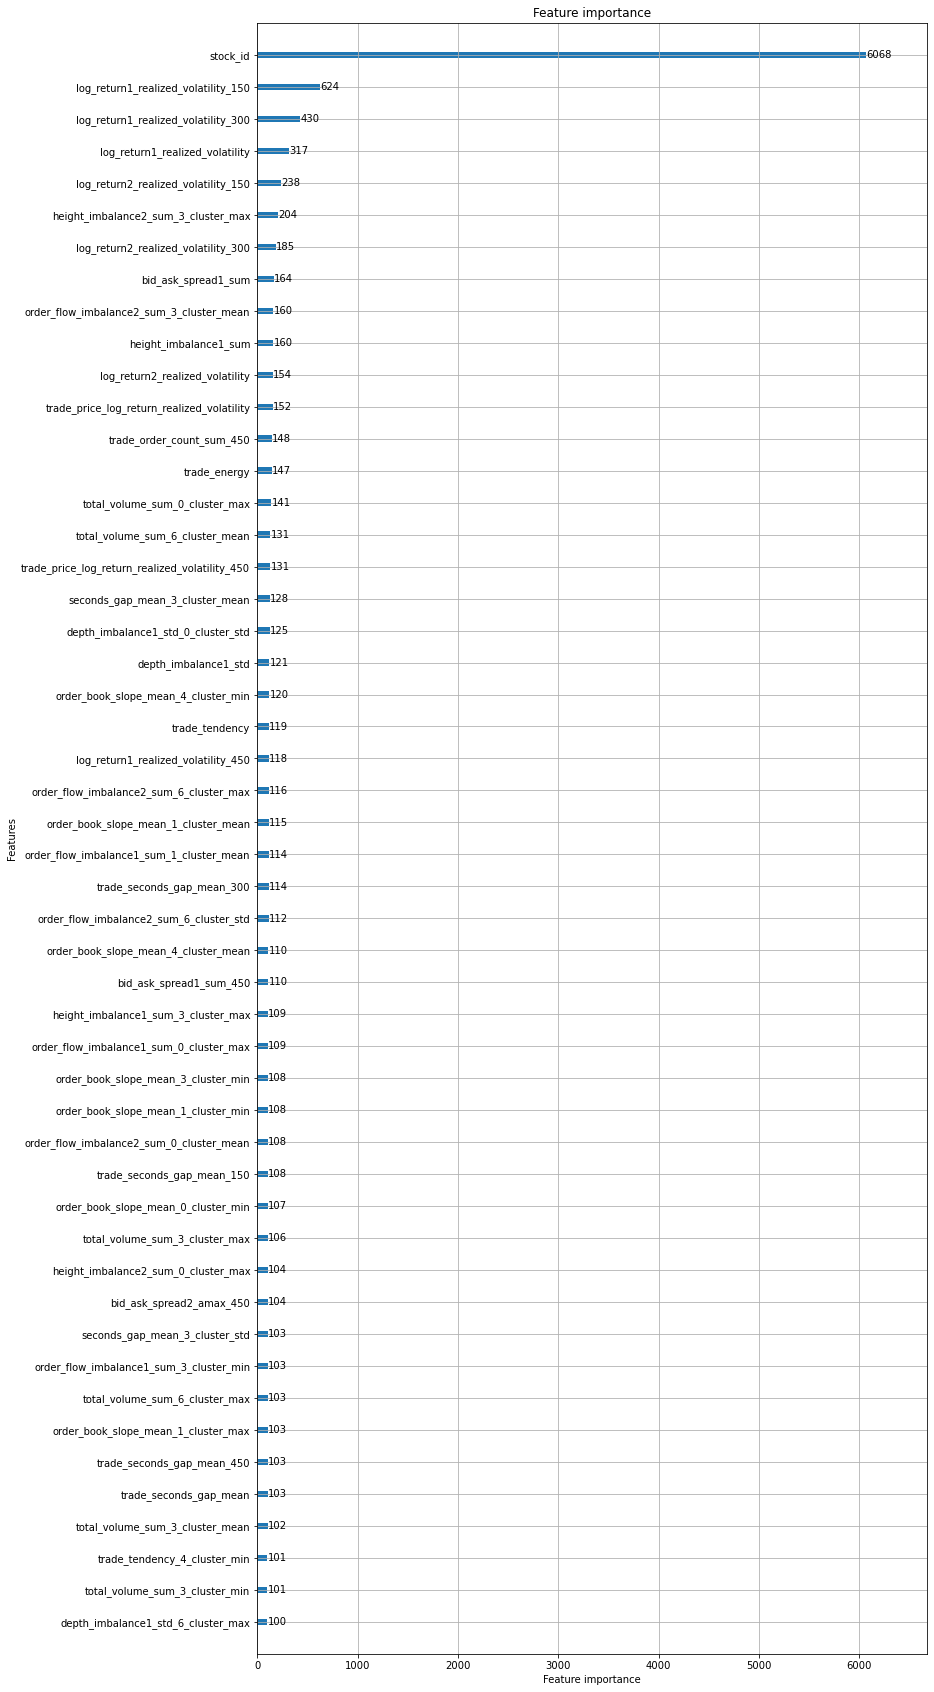

Training fold 2
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.000446765	training's RMSPE: 0.206351	valid_1's rmse: 0.000497408	valid_1's RMSPE: 0.232056
[200]	training's rmse: 0.000422293	training's RMSPE: 0.195048	valid_1's rmse: 0.000489931	valid_1's RMSPE: 0.228568
[300]	training's rmse: 0.000407675	training's RMSPE: 0.188296	valid_1's rmse: 0.000486202	valid_1's RMSPE: 0.226828
[400]	training's rmse: 0.00039809	training's RMSPE: 0.183869	valid_1's rmse: 0.000485176	valid_1's RMSPE: 0.226349
[500]	training's rmse: 0.000390422	training's RMSPE: 0.180328	valid_1's rmse: 0.000484787	valid_1's RMSPE: 0.226167
[600]	training's rmse: 0.000384499	training's RMSPE: 0.177592	valid_1's rmse: 0.000484226	valid_1's RMSPE: 0.225906
[700]	training's rmse: 0.00037945	training's RMSPE: 0.17526	valid_1's rmse: 0.000484498	valid_1's RMSPE: 0.226033
[800]	training's rmse: 0.000374949	training's RMSPE: 0.173181	valid_1's rmse: 0.000485655	valid_1's RMSPE: 0.2265

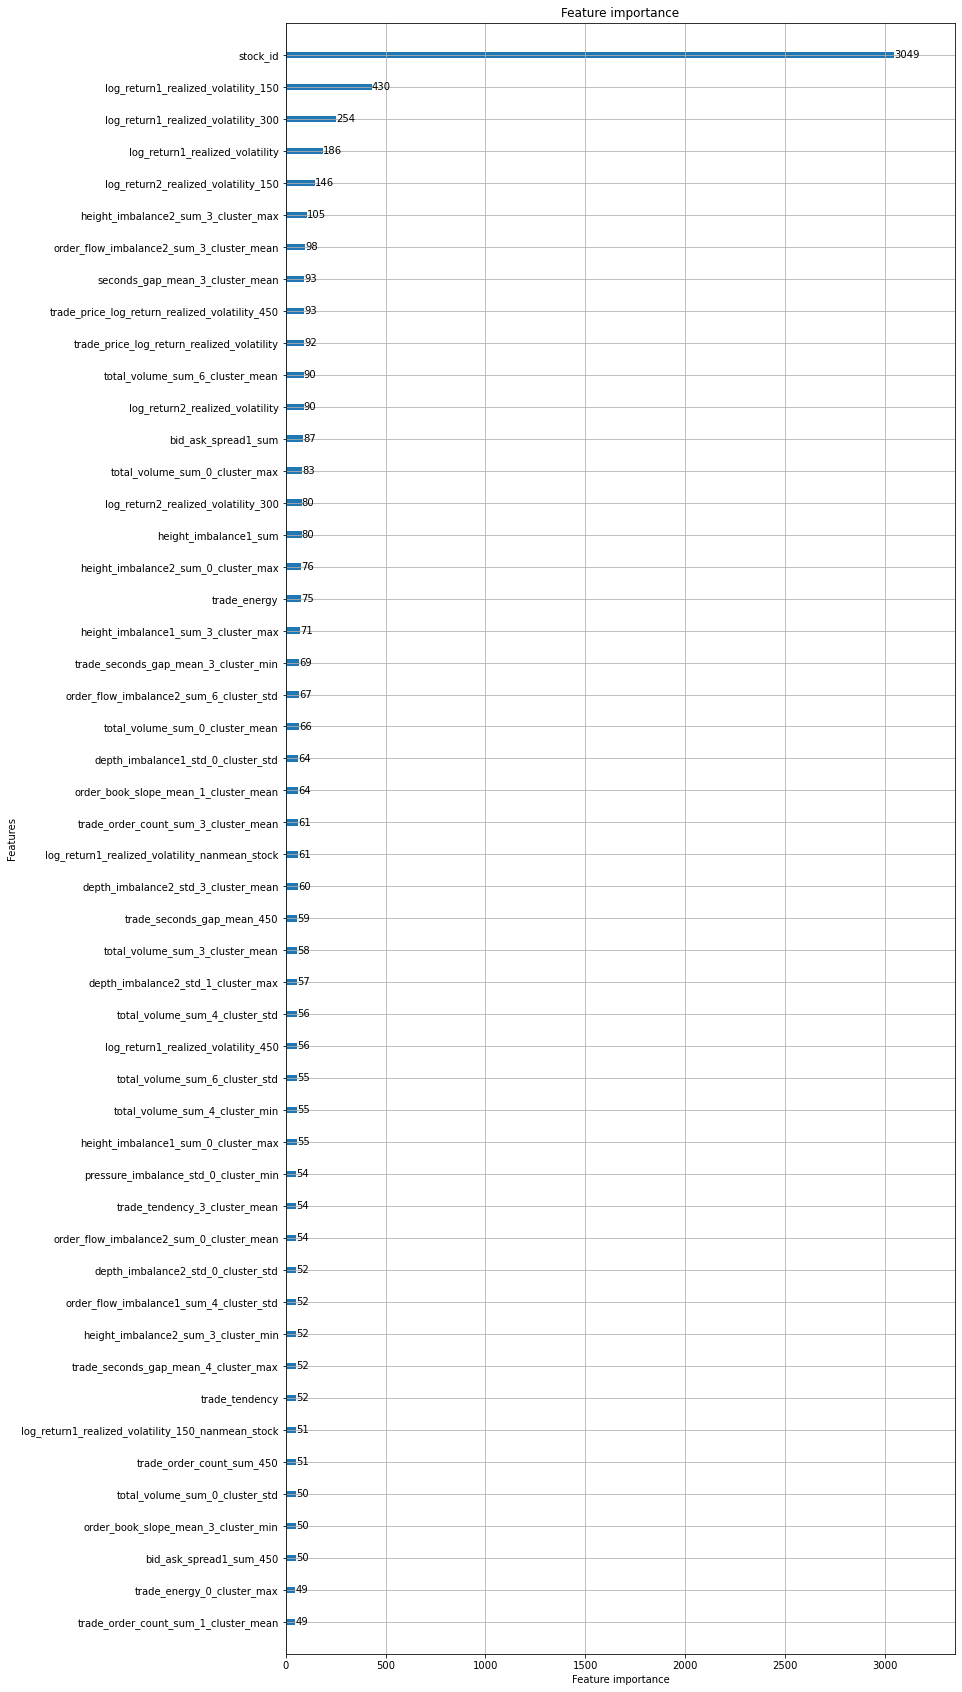

Training fold 3
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.000450185	training's RMSPE: 0.208061	valid_1's rmse: 0.000465642	valid_1's RMSPE: 0.216704
[200]	training's rmse: 0.000424823	training's RMSPE: 0.196339	valid_1's rmse: 0.000460966	valid_1's RMSPE: 0.214527
[300]	training's rmse: 0.000410204	training's RMSPE: 0.189583	valid_1's rmse: 0.00045884	valid_1's RMSPE: 0.213538
[400]	training's rmse: 0.000400239	training's RMSPE: 0.184977	valid_1's rmse: 0.000457245	valid_1's RMSPE: 0.212796
[500]	training's rmse: 0.000392629	training's RMSPE: 0.18146	valid_1's rmse: 0.000456406	valid_1's RMSPE: 0.212405
[600]	training's rmse: 0.000386408	training's RMSPE: 0.178585	valid_1's rmse: 0.000456261	valid_1's RMSPE: 0.212338
[700]	training's rmse: 0.000381234	training's RMSPE: 0.176194	valid_1's rmse: 0.000456297	valid_1's RMSPE: 0.212354
[800]	training's rmse: 0.000376763	training's RMSPE: 0.174127	valid_1's rmse: 0.000456511	valid_1's RMSPE: 0.212

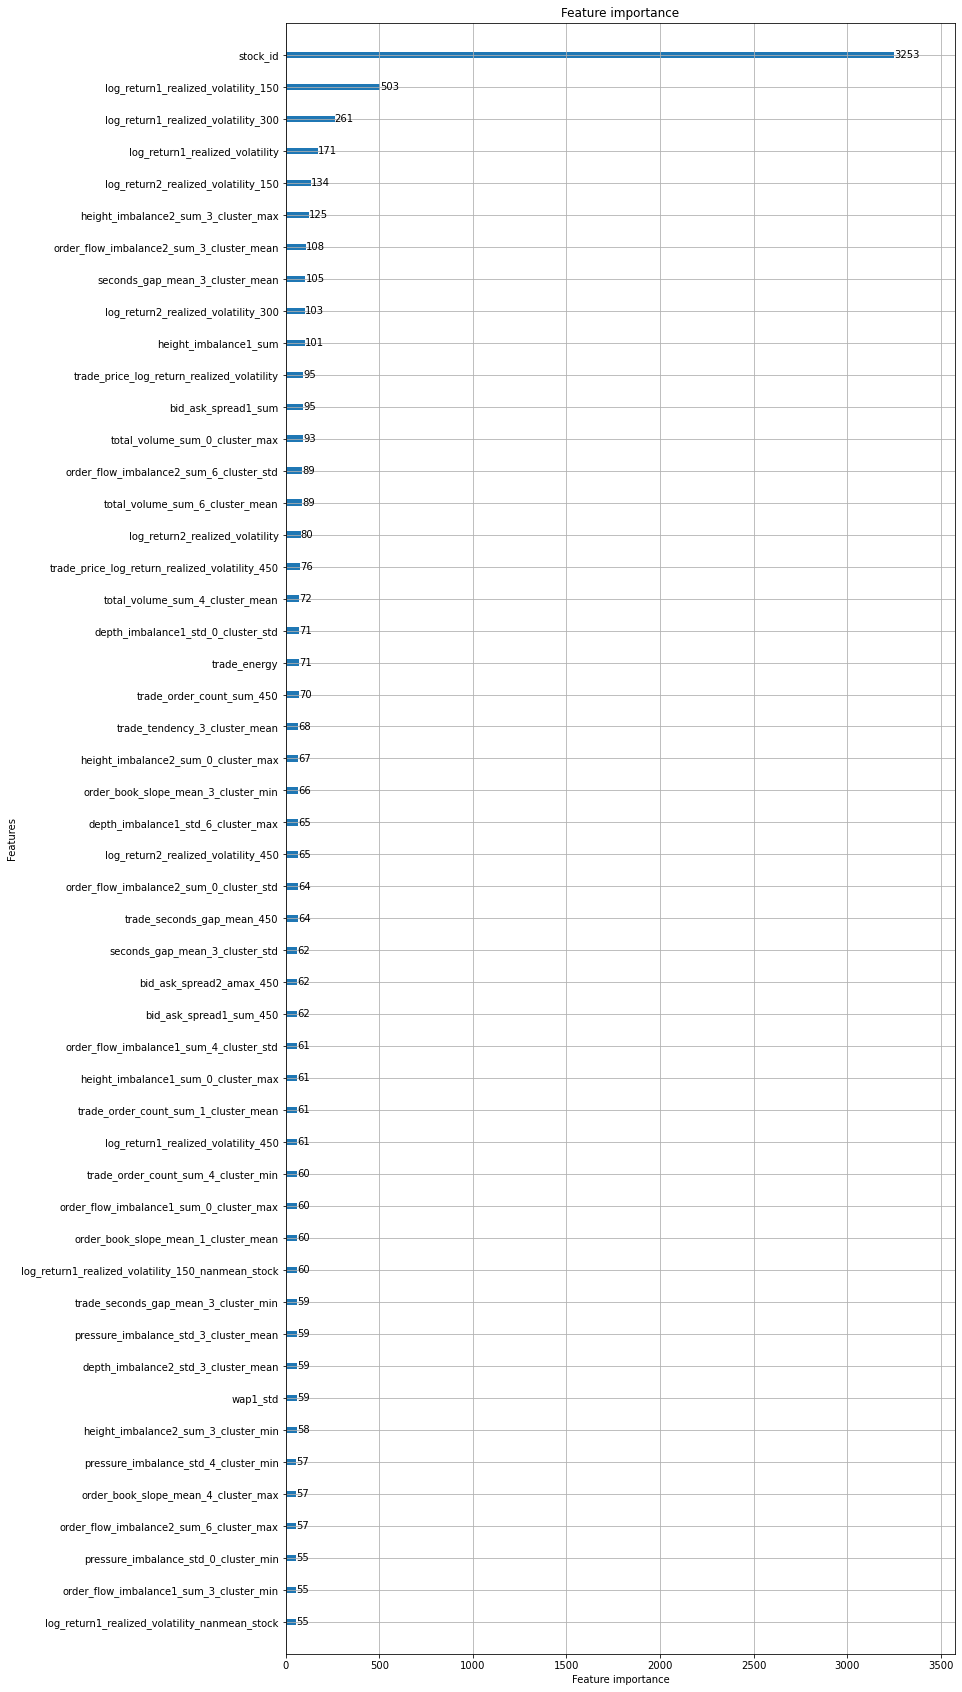

Training fold 4
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.000449891	training's RMSPE: 0.208174	valid_1's rmse: 0.000471689	valid_1's RMSPE: 0.218476
[200]	training's rmse: 0.00042472	training's RMSPE: 0.196527	valid_1's rmse: 0.000466316	valid_1's RMSPE: 0.215987
[300]	training's rmse: 0.000409917	training's RMSPE: 0.189677	valid_1's rmse: 0.000463999	valid_1's RMSPE: 0.214914
[400]	training's rmse: 0.000399922	training's RMSPE: 0.185052	valid_1's rmse: 0.000462995	valid_1's RMSPE: 0.214449
[500]	training's rmse: 0.00039235	training's RMSPE: 0.181549	valid_1's rmse: 0.000462552	valid_1's RMSPE: 0.214243
[600]	training's rmse: 0.000386308	training's RMSPE: 0.178753	valid_1's rmse: 0.000462564	valid_1's RMSPE: 0.214249
[700]	training's rmse: 0.00038122	training's RMSPE: 0.176399	valid_1's rmse: 0.000463225	valid_1's RMSPE: 0.214556
[800]	training's rmse: 0.00037668	training's RMSPE: 0.174298	valid_1's rmse: 0.000463993	valid_1's RMSPE: 0.21491

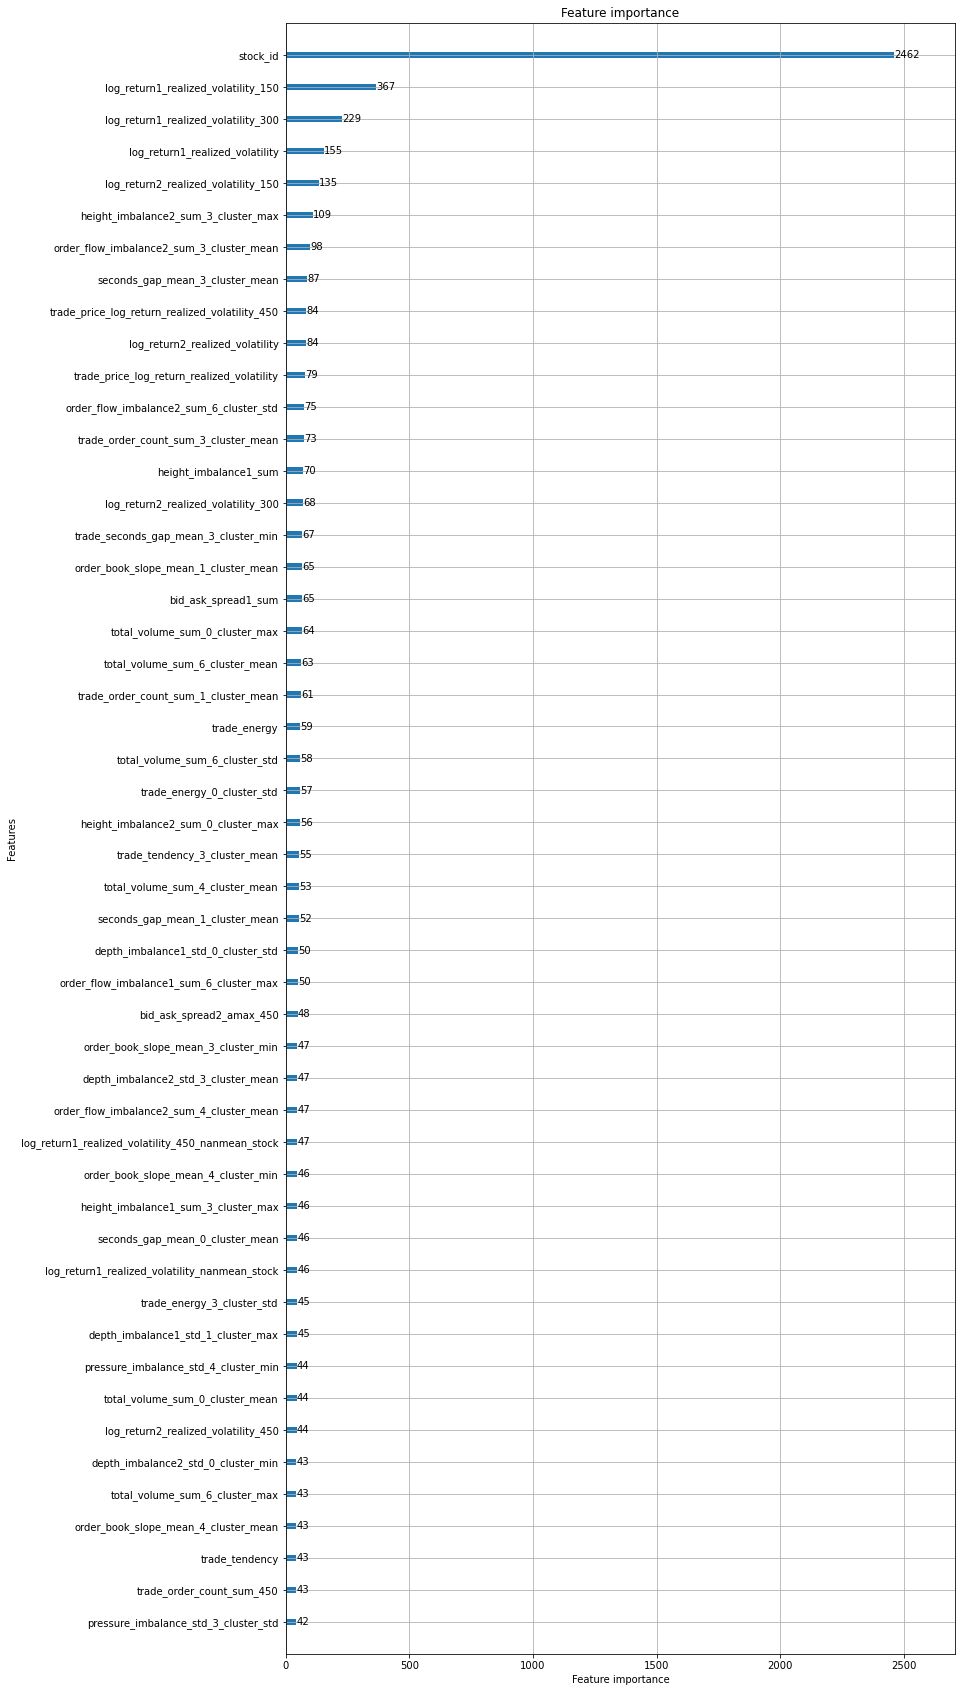

Training fold 5
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.00044944	training's RMSPE: 0.208575	valid_1's rmse: 0.000465953	valid_1's RMSPE: 0.213277
[200]	training's rmse: 0.000423859	training's RMSPE: 0.196703	valid_1's rmse: 0.000461724	valid_1's RMSPE: 0.211341
[300]	training's rmse: 0.00040956	training's RMSPE: 0.190067	valid_1's rmse: 0.000459751	valid_1's RMSPE: 0.210438
[400]	training's rmse: 0.000399442	training's RMSPE: 0.185372	valid_1's rmse: 0.000458975	valid_1's RMSPE: 0.210083
[500]	training's rmse: 0.000391916	training's RMSPE: 0.181879	valid_1's rmse: 0.000458506	valid_1's RMSPE: 0.209868
[600]	training's rmse: 0.000385916	training's RMSPE: 0.179095	valid_1's rmse: 0.000457985	valid_1's RMSPE: 0.20963
[700]	training's rmse: 0.000380785	training's RMSPE: 0.176714	valid_1's rmse: 0.00045811	valid_1's RMSPE: 0.209687
[800]	training's rmse: 0.000376294	training's RMSPE: 0.174629	valid_1's rmse: 0.000458234	valid_1's RMSPE: 0.20974

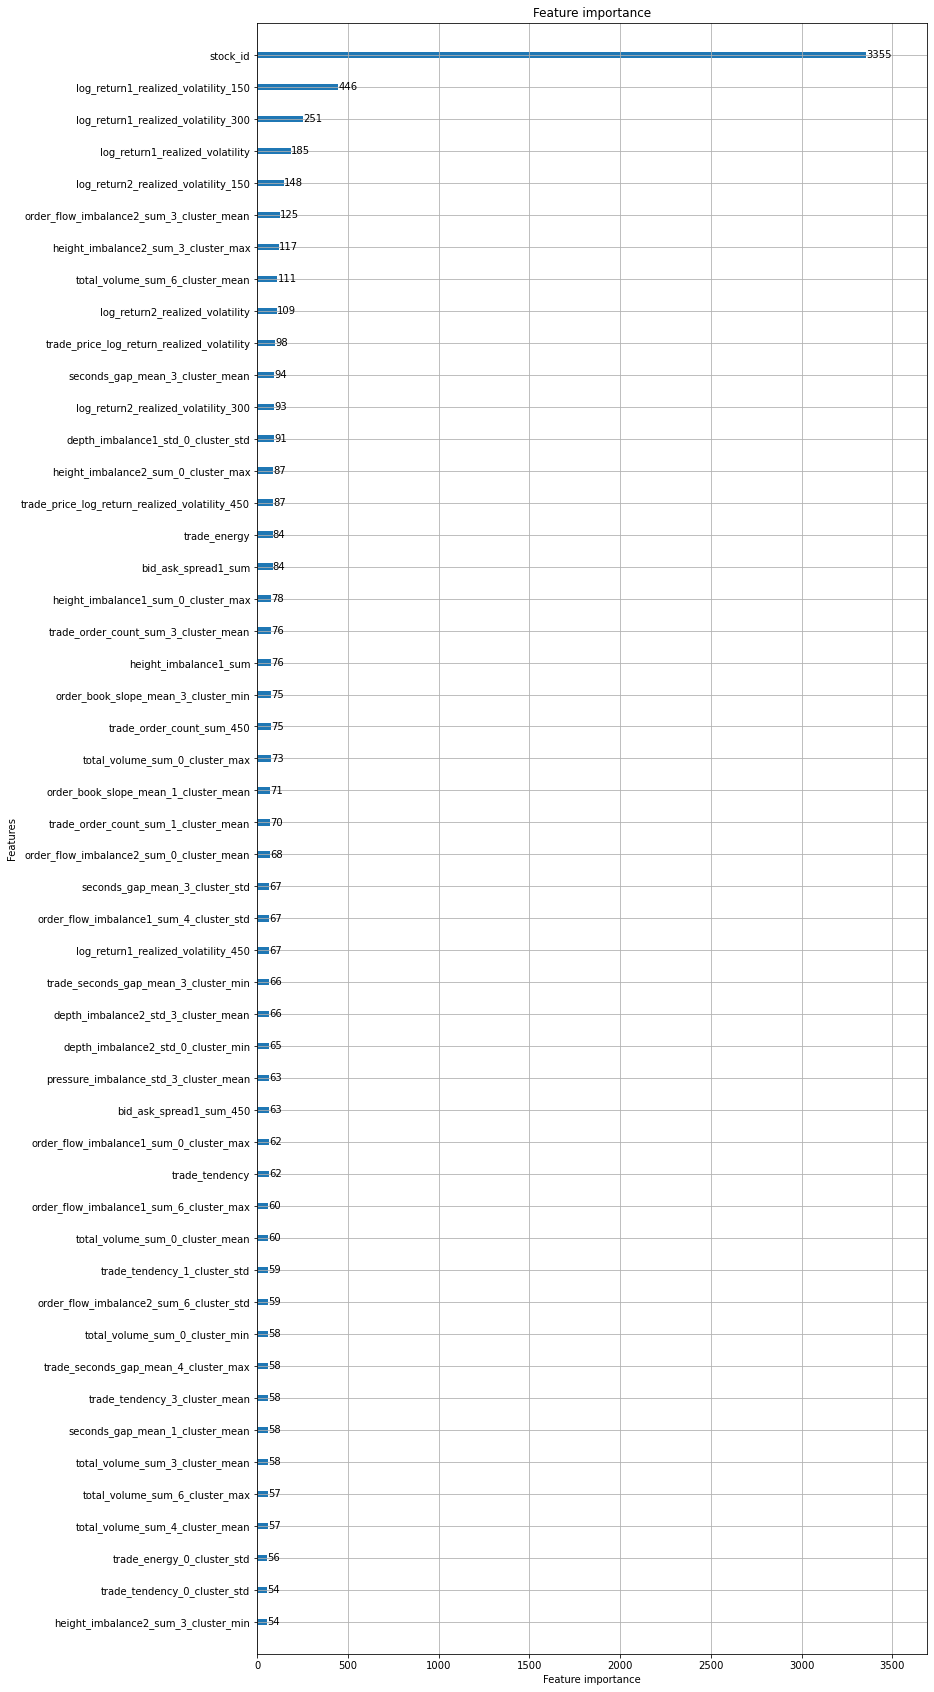

Our out of folds RMSPE is 0.21541103996743916


In [39]:
# Traing and evaluate
test_predictions = train_and_evaluate(train, test)

# Save test predictions
# test["target"] = test_predictions
# test[["row_id", "target"]].to_csv("submission.csv",index = False)

In [ ]:
# GroupKfold Our out of folds RMSPE is 0.21541103996743916